Maximum Mass (kg) =  3500
Minimum Mass (kg) =  100
Maximum Thrust (N) =  60000



Running 100 Monte Carlo Simulations with noise...
Simulating flight 10/100...
Simulating flight 20/100...
Simulating flight 30/100...
Simulating flight 40/100...
Simulating flight 50/100...
Simulating flight 60/100...
Simulating flight 70/100...
Simulating flight 80/100...
Simulating flight 90/100...
Simulating flight 100/100...


MONTE CARLO RESULTS (N=100)
Success Rate      : 100.0%
Avg Fuel Remaining: 97.17 kg
Best Flight Fuel : 99.98 kg
Worst Flight Fuel: 94.58 kg


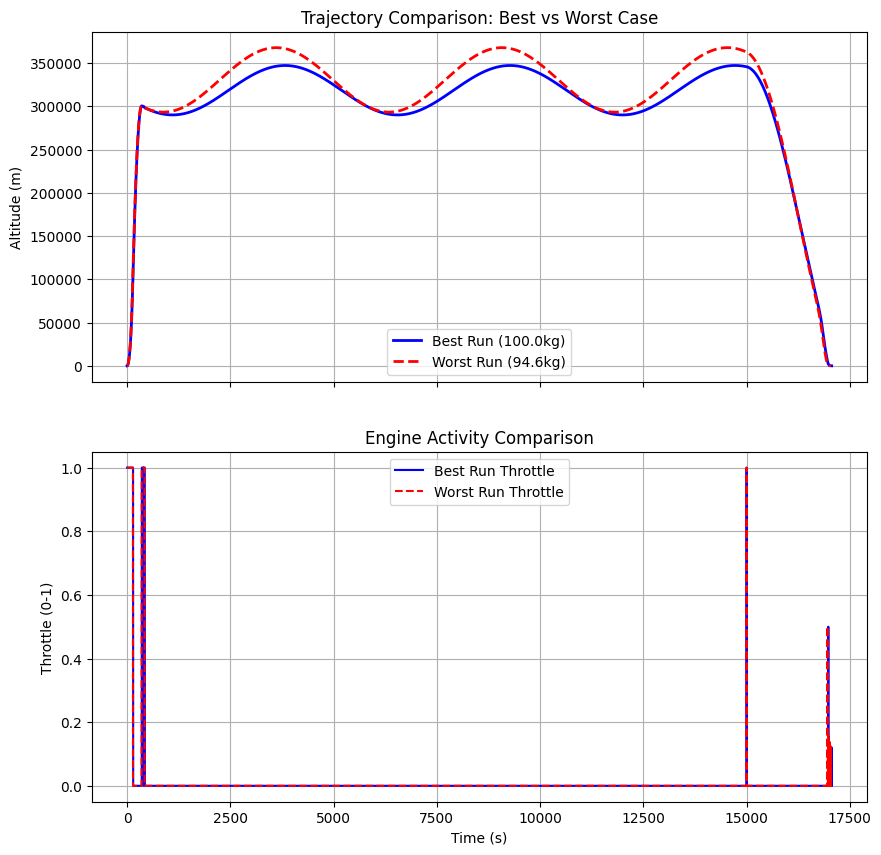

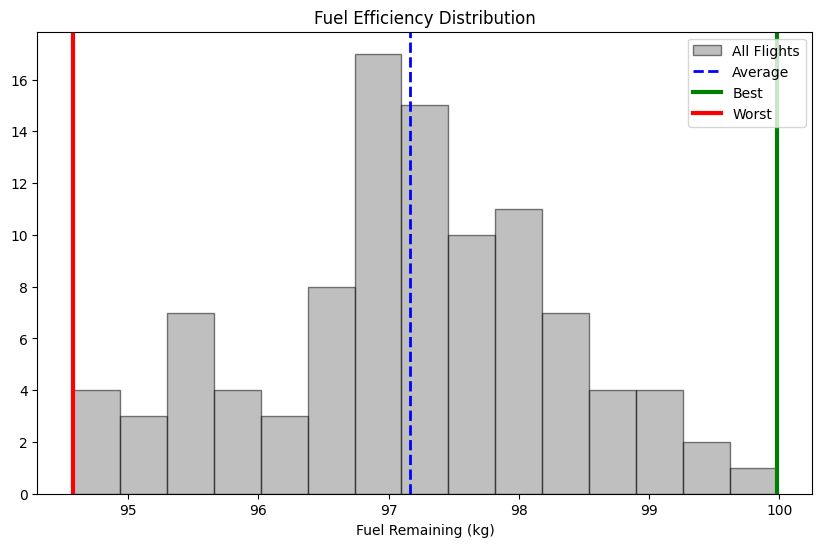

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math

# SYSTEM PARAMETERS
class Params:
    def __init__(self, m_full, m_empty, T_max):
        self.g0 = 9.81          # Gravity (m/s^2)
        self.m_full = m_full    # Starting Mass (kg)
        self.m_empty = m_empty    # Empty Mass (kg)
        self.rho = 1.225        # Air density
        self.Cd = 0.2           # Drag coefficient
        self.A = 1.0            # Area
        self.T_max = T_max    # Max Thrust (N)
        self.Isp = 400.0        # Specific Impulse
        self.Re = 6371000       # Earth Radius (m)

# PHYSICS FUNCTION
def get_derivatives(state, s, throttle, pitch_angle, alt):
    # state: [vx, vy, mass]
    vx = state[2]
    vy = state[3]
    mass = state[4]

    # Thrust (Newtons)
    F_thrust = throttle * s.T_max 

    Fx_thrust = F_thrust * np.cos(pitch_angle) # x direction of the Thrust
    Fy_thrust = F_thrust * np.sin(pitch_angle) # y direction of the Thrust

    # Drag (Newtons)
    v_mag = np.sqrt(vx**2 + vy**2) # magnitude of the velocity

    current_rho = s.rho * np.exp(-alt / 8500.0) # atomspheric dragging constant based on current altitude

    k_drag = 0.5 * current_rho * s.A * s.Cd # Drag force constant
    F_drag = -k_drag * (v_mag**2) 

    if v_mag > 0.1:
        flight_path_angle = np.arctan2(vy, vx) # direction of the movement of the spacecraft
    else:
        flight_path_angle = np.pi/2
        
    Fx_drag = F_drag * np.cos(flight_path_angle) # x component of the Drag
    Fy_drag = F_drag * np.sin(flight_path_angle) # y component of the Drag
    
    # Acceleration (F/m)
    a_centrif = (vx**2) / (s.Re + alt) # acceleration of centrifugal force
    g_local = s.g0 * (s.Re / (s.Re + alt))**2 # gravitational acceleration based on current altitude
    
    ax = (Fx_thrust + Fx_drag) / mass - ((vx * vy) / (s.Re + alt)) # x component of the acceleration
    ay = (Fy_thrust + Fy_drag) / mass - g_local + a_centrif # y component of the acceleration
    
    # Mass Flow
    if throttle > 0.0:
        dm = -F_thrust / (s.Isp * s.g0)
    else:
        dm = 0.0
    
    return np.array([vx, vy, ax, ay, dm])

# MAIN SIMULATION LOOP
def run_simulation(user_m_full, user_m_empty, user_T_max, noise_level = 0.0):
    s = Params(user_m_full, user_m_empty, user_T_max) # pass user inputs to Params

    vx_noise = np.random.normal(0.0, 5.0 * noise_level) # initial horizontal velocity of the rocket caused by external factors such as wind
    mass_noise = np.random.normal(0.0, 20.0 * noise_level) # initial mass of the rocket as fuel is not perfectly full
    # Initial State: [Distance=0m, Altitude=0m, x Velocity=wind_vx m/s, y Velocity=0m/s, Mass=s.m_fullkg]
    state = np.array([0.0, 0.0, vx_noise, 0.0, s.m_full + mass_noise])
    
    t = 0.0 # start time (s)
    dt = 0.1 # change of time per loop (s)
    t_end = 20000.0 # end time (s)
    
    # Logging
    history = {'dist': [], 't': [], 'alt': [], 'vx': [], 'vy': [], 'throttle': [], 'mass': []}

    mission_complete = False
    deorbit_complete = False
    
    while t < t_end:
        dist = state[0]
        alt = state[1]
        vx = state[2]
        vy = state[3]
        mass = state[4]

        # Keplerian Math
        mu = 3.986e14 # standard gravitational parameter (G * M)
        r = s.Re + alt # current distance from the center of the Earth
        v_mag = np.sqrt(vx**2 + vy**2)

        flight_path_angle = np.arctan2(vy, vx)
        
        specific_energy = (v_mag**2 / 2) - (mu / r) # Specific Energy (Vis-Viva)

        # Orbit Prediction 
        if specific_energy < 0:
            # Elliptical Orbit Math
            a = -mu / (2 * specific_energy)
            # Eccentricity
            h = r * vx # angular momentum approx
            e_term = 1 + (2 * specific_energy * h**2) / (mu**2)
            if e_term > 0:
                e = np.sqrt(e_term)
            else:
                e = 0
            R_apoapsis = a * (1 + e) # apoapsis
            predicted_alt = R_apoapsis - s.Re
        else:
            predicted_alt = 999999999.0 # Escape velocity!
        
        target_alt = 300000.0

        if mission_complete:
            throttle = 0.0
            pitch_angle = 0.0
        elif predicted_alt < target_alt: 
            throttle = 1.0
            pct = v_mag / 4000.0 # perform the following at v_mag = 4000 m/s
            # the spacecraft turns itself horizontally (0 degree) 
            if pct >= 1.0:
                pct = 1.0
            pitch_angle = np.pi/2 * (1 - pct)
        elif vy > 0.1: # perform the following if vy is greater than 0.1, meaning the spacecraft is going upward faster than it should be
            throttle = 0.0
            pitch_angle = 0.0 # direction of the orientation of the spacecraft
        else:
            req_vel = np.sqrt(mu / (s.Re + alt))            
            if vx < req_vel:
                throttle = 1.0
                pitch_angle = -20 * (vy / vx) # enables the spacecraft to thrust in the opposite direction of its movement to maintain its altitude
            else:
                throttle = 0.0
                pitch_angle = 0.0
                mission_complete = True

        R_periapsis = a * (1 - e) # periapsis
        predicted_peri = R_periapsis - s.Re
        
        if t > 15000 and not deorbit_complete: # start at t = 15000s
            if predicted_peri > 40000: # tilt the spacecraft to the opposite side of its movement to lower x velocity
                pitch_angle = flight_path_angle + np.pi
                throttle = 1.0
            else: # stop when altitude becomes 40000m
                throttle = 0.0
                deorbit_complete = True

        if deorbit_complete and alt < 2000: # perform the following when altitude gets lower and now reach 2000 m
            if abs(vx) > 0.5: # we want x velocity to be very small, so perform the following to minimize vx
                pitch_angle = flight_path_angle + np.pi # resume tilting the spacecraft to the opposite side of its movement to lower x velocity
                throttle = 0.5
            else: # if the absolute value of vx is very small
                pitch_angle = np.pi/2 # just think the angle of the spacecraft as 90 degrees
                target_vy = -(2.0 + (alt * 0.05)) # the spacecraft knows what value of vy it should have at current altitude

                g_force = mass * s.g0
                hover_throttle = g_force / s.T_max # as the mass keeps decreasing as the fuel burns, this let the spacecraft know how much it needs to throttle

                noise = np.random.normal(0.0, 0.5 * noise_level)
                measured_vy = vy + noise # the y velocity of the spacecraft the sensor measured is the original vy plus the noise of vy
                
                error = target_vy - measured_vy # difference between the target y velocity and current y velocity
                Kp = 0.05
                
                req_throttle = hover_throttle + (error * Kp) # determines how aggressively the engine reacts to errors

                throttle = max(0.0, min(1.0, req_throttle)) # set the range of throttle from 0 to 1
        
        derivatives = get_derivatives(state, s, throttle, pitch_angle, alt)
        state = state + (derivatives * dt) # updates the state

        if state[4] <= s.m_empty: # sets mass as 100 kg if the calculated mass is smaller than or equal to 100 kg
            state[4] = s.m_empty
            throttle = 0.0 # and set throttle as 0 as mass being equal to 100 kg means there is no remaining fuel

        if state[1] < 0.0: # if the calculated altitude is lower than 0, stop the simulation
            break

        history['t'].append(t)
        history['dist'].append(dist)
        history['alt'].append(alt)
        history['vx'].append(vx)
        history['vy'].append(vy)
        history['throttle'].append(throttle)
        history['mass'].append(mass)

        # Updates Time & Log
        t += dt
    
    success = False

    final_vx = state[2]
    final_vy = state[3]
    final_mass = state[4]
    
    if final_vy > -5.0:
        if abs(final_vx) < 2.0:
            if final_mass > s.m_empty:
                success = True # we set the mission as success if the properties of the spacecraft satisfy the above conditions

    delta_mass = final_mass - s.m_empty
    return success, delta_mass, history

# PLOTTING
# Main Monte Carlo Loop
if __name__ == '__main__':
    user_m_full = float(input('Maximum Mass (kg) = '))
    user_m_empty = float(input('Minimum Mass (kg) = '))
    user_T_max = float(input('Maximum Thrust (N) = '))

    N_runs = 100 # let the simulation run 100 times
    print(f'\nRunning {N_runs} Monte Carlo Simulations with noise...')

    # Spaces where data for each simulation is stored
    results = [] # store 1 if success, 0 if fail
    fuels = [] # store the amount of fuel left after each simulation is over

    best_run = {'fuel': -1.0, 'history': None} # max fuel found so far
    worst_run = {'fuel': float('inf'), 'history': None} # min fuel found so far

    for i in range(N_runs):
        is_success, fuel_left, flight_log = run_simulation(user_m_full, user_m_empty, user_T_max, noise_level=1.0)

        results.append(is_success)
        
        if is_success: 
            fuels.append(fuel_left) 
            
            # check if it is the best flight (most fuel left)
            if fuel_left > best_run['fuel']:
                best_run['fuel'] = fuel_left
                best_run['history'] = flight_log
            
            # check if it is the worst flight (least fuel left)
            if fuel_left < worst_run['fuel']:
                worst_run['fuel'] = fuel_left
                worst_run['history'] = flight_log

        if (i + 1) % 10 == 0:
            print(f'Simulating flight {i + 1}/{N_runs}...') # display the progress to let the user the simulation is working

    # Results Analysis
    success_rate = (sum(results) / N_runs) * 100
    if fuels:
        avg_fuel = np.mean(fuels)
    else:
        avg_fuel = 0.0

    print('\n')
    print('============================')
    print(f'MONTE CARLO RESULTS (N={N_runs})')
    print('============================')
    print(f'Success Rate      : {success_rate:.1f}%')
    print(f'Avg Fuel Remaining: {avg_fuel:.2f} kg')
    print('============================')
    
    if best_run['history']:
        print(f'Best Flight Fuel : {best_run['fuel']:.2f} kg')
        print(f'Worst Flight Fuel: {worst_run['fuel']:.2f} kg')

    if fuels and best_run['history']: # let the program create a plot only if there was at least one successful landing
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True) # a figure with 2 subplots (Altitude and Throttle)

        # Altitude Plot
        t_best = best_run['history']['t']
        alt_best = best_run['history']['alt']
        t_worst = worst_run['history']['t']
        alt_worst = worst_run['history']['alt']

        ax1.plot(t_best, alt_best, 'b-', linewidth=2, label=f'Best Run ({best_run['fuel']:.1f}kg)')
        ax1.plot(t_worst, alt_worst, 'r--', linewidth=2, label=f'Worst Run ({worst_run['fuel']:.1f}kg)')
        
        ax1.set_ylabel('Altitude (m)')
        ax1.set_title('Trajectory Comparison: Best vs Worst Case')
        ax1.grid(True)
        ax1.legend()
        
        # Throttle Plot
        thr_best = best_run['history']['throttle']
        thr_worst = worst_run['history']['throttle']
        
        ax2.plot(t_best, thr_best, 'b-', linewidth=1.5, label='Best Run Throttle')
        ax2.plot(t_worst, thr_worst, 'r--', linewidth=1.5, label='Worst Run Throttle')
        
        ax2.set_ylabel('Throttle (0-1)')
        ax2.set_xlabel('Time (s)')
        ax2.set_title('Engine Activity Comparison')
        ax2.grid(True)
        ax2.legend()
        
        plt.show()

        # Histogram (Fuel Efficiency)
        plt.figure(figsize=(10, 6))
        plt.hist(fuels, bins=15, color='gray', alpha=0.5, edgecolor='black', label='All Flights')
        plt.axvline(avg_fuel, color='blue', linestyle='dashed', linewidth=2, label='Average')
        plt.axvline(best_run['fuel'], color='green', linewidth=3, label='Best')
        plt.axvline(worst_run['fuel'], color='red', linewidth=3, label='Worst')
        plt.title('Fuel Efficiency Distribution')
        plt.xlabel('Fuel Remaining (kg)')
        plt.legend()
        plt.show()
    else:
        print('No successful landings to plot.')